# core

> core utils

[![](https://raw.githubusercontent.com/butchland/fastai-torchgeo/master/assets/colab.svg)](https://colab.research.google.com/github/butchland/fastai-torchgeo/blob/master/nbs/00_core.ipynb)

In [1]:
#| default_exp core

In [2]:
#| hide
# check if in colab and install package as needed
![ -e /content ] && ! pip show fastai-torchgeo && pip install git+https://github.com/butchland/fastai-torchgeo.git
![ -e /content ] && ! pip show nbdev && pip install nbdev

In [3]:
#| exporti
import rasterio as rio
import numpy as np
import pathlib
import torch as th
import fastai.vision.all as fv
import fastcore.all as fc
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Union
from functools import partial

/home/studio-lab-user/.conda/envs/fastai-torchgeo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#| export
def load_tif(fpath:Union[str,pathlib.Path], # filename 
             chnls_last=True, # transpose from c,h,w to h,w,c (assume c,h,w on rio.read input)
            ) -> np.ndarray: # ndarray will return either h,w,c or c,h,w depending on chnls_last is True or False
    """
    Loads a geotiff file, transpose its channels if necessary, and return the image data as a numpy array.
    
    #### Parameters
    
    - `fpath` (str|pathlib.Path): The file path of the image to be loaded.
    - `chnls_last` (bool, optional): If set to `True`, the function will return the image data in the format (height, width, channels) (h, w, c). If set to `False`, the function will return the image data in the format (channels, height, width) (c, h, w). Default value is `True`.
    
    #### Returns
    
    - `numpy.ndarray`: The image data as a NumPy array. The shape of the array depends on the value of `chnls_last`.
      - If `chnls_last` is `True`, the returned array will have the shape `(height, width, channels)`.
      - If `chnls_last` is `False`, the returned array will have the shape `(channels, height, width)`.
    """
    with rio.open(fpath) as src:
        data = src.read()
    if chnls_last:
        return data.transpose([1,2,0]) # return as h,w,c
    return data

#### Explore loading geotiffs

In [5]:
from torchgeo.datasets import EuroSAT100
import fastai.vision.all as fv

In [6]:
# load a sample geotiff dataset
sat_path = fv.untar_data(EuroSAT100.url); sat_path

Path('/home/studio-lab-user/.fastai/data/EuroSAT100')

In [7]:
sat_path.ls()

(#1) [Path('/home/studio-lab-user/.fastai/data/EuroSAT100/images')]

In [8]:
sat_images = fv.get_image_files(sat_path); len(sat_images)

100

In [9]:
sat_image = sat_images[10]; sat_image

Path('/home/studio-lab-user/.fastai/data/EuroSAT100/images/remote_sensing/otherDatasets/sentinel_2/tif/River/River_1690.tif')

In [10]:
data = load_tif(sat_image) # channels last is the default
(type(data), data.shape) # height,width, channels

(numpy.ndarray, (64, 64, 13))

In [11]:
data = load_tif(sat_image, chnls_last=False)
data.shape # channels, height, width

(13, 64, 64)

In [12]:
#| export
def open_tif(fn:Union[str,pathlib.Path], # The path to the TIFF image file
             chnls:[int]=None, # The channels to load from the image
             chnls_last:bool=True, # If True, the channel dimension is the last dimension
             cls=th.Tensor, # The class of the tensor to create
            ) -> th.Tensor: # A tensor array of the image 
    """
    Creates a tensor from a TIFF image file. 
    
    #### Parameters
    
    - `fn` (str): The path to the TIFF image file.
    - `chnls` (list of int, optional): The channels to load from the image. Default to `None`, which loads all channels
    - `chnls_last` (bool, optional): If `True`, the channel dimension is the last dimension. Default to `True`.
    - `cls` (class, optional): The class of the tensor to create. Defaults to `torch.Tensor`
        
    #### Returns
    
    - `Tensor`: A pytorch tensor created from the TIFF image file.
    """
    
    arr = load_tif(fn, chnls_last=chnls_last)
    if chnls is not None:
        arr = arr[..., chnls] if chnls_last else arr[..., chnls, :,:]
    th_arr = th.from_numpy(arr.astype(np.int32)).type(th.float32)
    return cls(th_arr)


#### Loading geotiffs as Tensors 

In [13]:
t1 = open_tif(sat_image)

In [14]:
(type(t1), t1.shape)

(torch.Tensor, torch.Size([64, 64, 13]))

In [15]:
#| export

class GeoTensorImage(fv.TensorImage):
    """
    A TensorImage for geotiffs

    Can contain more than 3 channels (e.g. 12 band sentinel-2 images) as well as a 
    bigger range of values (16-bit vs 8-bit) than your typical image formats

    #### Attributes
    
    - `chnls_first` (bool): If True, the format of the tensor is c,h,w else its h,w,c
                            where c = channels, h = height, w = width

    #### Methods
    
    - `create(data, chnls, chnls_first)`: (classmethod) create a `GeoTensorImage` from a file or numpy array
    - `show(chnls,scaler,bright, ctx)`: display a GeoTensorImage
    """
    
    def __init__(self, x, chnls_first=False):
        self.chnls_first = chnls_first
        
    def __repr__(self):
        return (f'GeoTensorImage: {self.shape}')

    @classmethod
    def create(cls, # GeoTensorImage Class or GeoTensorImage subclass to instantiate
               data:Union[Path,str,np.ndarray], # The image data that the class method is called on.
               chnls:[int]=None, # An optional list of channels to filter. Defaults to None, which does no filtering
               chnls_first:bool=True, # A boolean flag indicating whether the channels are returned c,h,w or h,w,c. Defaults to True - c,h,w
              ) -> fv.TensorImage: # An instance of the TensorImage class with appropriate image formatting.
        """
        (class method) Returns an instance of the class with the input image data formatted appropriately. 

        If input is Path/str and ends with "tif", opens it using open_tif function. 
        If input is np.ndarray, transposes it if chnls_first. 
        Otherwise, input is used as is.

        ## Parameters:

        - `data` (Union[Path, str, np.ndarray]): The image data that the class method is called on.
        - `chnls` ([int]): An optional list of channels to filter. Defaults to None, which does no filtering.
        - `chnls_first` (bool, optional): A boolean flag indicating whether the channels are in the first or last 
                                          dimension of the input array. Defaults to True.

        ## Returns

        - GeoTensorImage: An instance of the GeoTensorImage class with appropriate image formatting.

        """

        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('tif'): im = open_tif(fn=data, chnls=chnls, chnls_last = not chnls_first, cls=th.Tensor)
        elif isinstance(data, np.ndarray):
            if chnls_first:
                # assume chnls last coming in
                data = data.transpose([2,0,1]) # data out  as c,h,w
            im = th.from_numpy(data)
        else:
            im = data

        return cls(im, chnls_first=chnls_first)

    def show(self,
             chnls:[int]=[3, 2, 1], # list of chnls to include
             scaler:float=1.0, # 
             bright:float=1.0, 
             ctx:mpl.axes.Axes=None,
            ) -> mpl.image.AxesImage:
        """
        Shows the GeoTensorImage object in a matplotlib figure.

        Args:
            chnls: A list of channel indices to show. The default is [3, 2, 1].
            scaler: A float value to scale the image by. The default is 1.0.
            bright: A float value to brighten the image by. The default is 1.0.
            ctx: A matplotlib context object. The default is None.

        Returns:
            The matplotlib Axes image.
        """   
        if self.ndim > 2:
            visu_img = self[..., chnls] if not self.chnls_first else self.permute([1, 2, 0])[..., chnls]
        else:
            visu_img = self

        visu_img = visu_img.squeeze()
        if scaler is None:
            visu_img /= visu_img.max()
        else:
            visu_img /= visu_img.max() * scaler

        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)

        plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)

        return ctx


In [16]:
GeoTensorImage.create?

Signature:
GeoTensorImage.create(
    data: Union[pathlib.Path, str, numpy.ndarray],
    chnls: [<class 'int'>] = None,
    chnls_first: bool = True,
) -> fastai.torch_core.TensorImage
Docstring:
(class method) Returns an instance of the class with the input image data formatted appropriately. 

If input is Path/str and ends with "tif", opens it using open_tif function. 
If input is np.ndarray, transposes it if chnls_first. 
Otherwise, input is used as is.

## Parameters:

- `data` (Union[Path, str, np.ndarray]): The image data that the class method is called on.
- `chnls` ([int]): An optional list of channels to filter. Defaults to None, which does no filtering.
- `chnls_first` (bool, optional): A boolean flag indicating whether the channels are in the first or last 
                                  dimension of the input array. Defaults to True.

## Returns

- GeoTensorImage: An instance of the GeoTensorImage class with appropriate image formatting.
File:      /tmp/ipykernel_251/124

#### Creating GeoTensorImages from a file

In [17]:
geo_img = GeoTensorImage.create(sat_image)

In [18]:
geo_img

GeoTensorImage: torch.Size([13, 64, 64])

In [19]:
geo_img.show?

Signature:
geo_img.show(
    chnls: [<class 'int'>] = [3, 2, 1],
    scaler: float = 1.0,
    bright: float = 1.0,
    ctx: matplotlib.axes._axes.Axes = None,
) -> matplotlib.image.AxesImage
Docstring:
Shows the GeoTensorImage object in a matplotlib figure.

Args:
    chnls: A list of channel indices to show. The default is [3, 2, 1].
    scaler: A float value to scale the image by. The default is 1.0.
    bright: A float value to brighten the image by. The default is 1.0.
    ctx: A matplotlib context object. The default is None.

Returns:
    The matplotlib Axes image.
File:      /tmp/ipykernel_251/1243907552.py
Type:      method

#### Showing GeoTensorImages

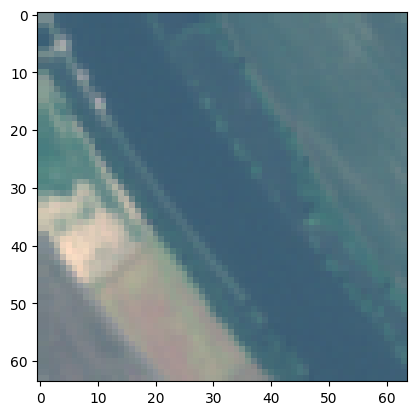

In [20]:
geo_img.show();

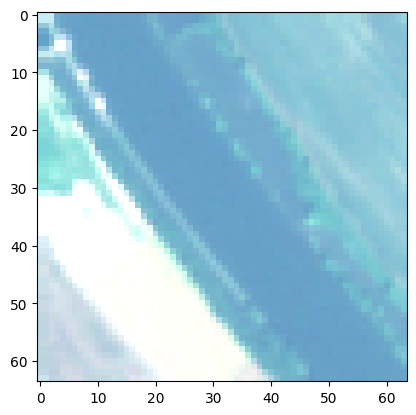

In [21]:
geo_img.show(bright=1.7);

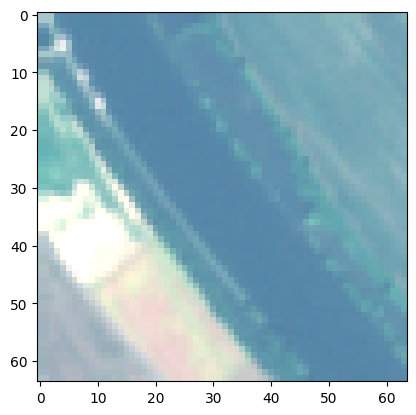

In [22]:
geo_img.show(scaler=0.7);

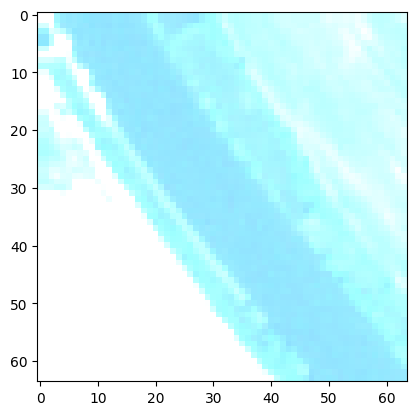

In [23]:
geo_img.show(scaler=0.7, bright=1.7);

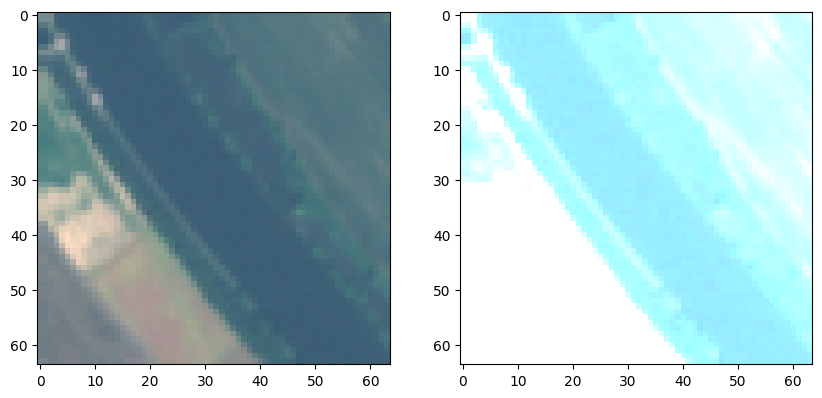

In [24]:
fig,ax = plt.subplots(1, 2, figsize=(10,10))
geo_img.show(ctx=ax[0])
geo_img.show(ctx=ax[1], scaler=0.4)
plt.show()